In [108]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import cv2

from tqdm.auto import tqdm

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

(3024, 3024, 3)

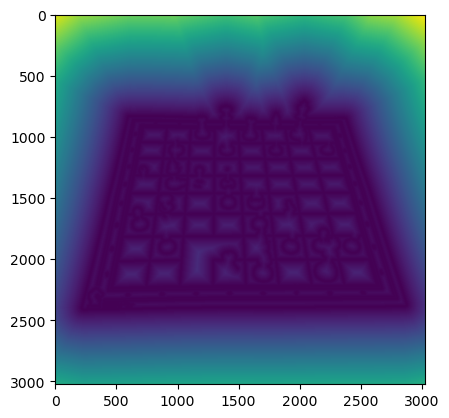

In [137]:
image_file_path = "data/image1.jpg"
img = np.array(Image.open(image_file_path))
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 1)
img_edge = cv2.Canny(img_blur, 100, 700)
d = torch.tensor(cv2.distanceTransform(255-img_edge, cv2.DIST_L2, 5)).to(device)
plt.imshow(d);
img.shape

(array([[  8.,   0., 488.],
        [  0.,   8., 488.],
        [  0.,   0.,   1.]]),
 (3024, 3024),
 tensor(1004.0054))

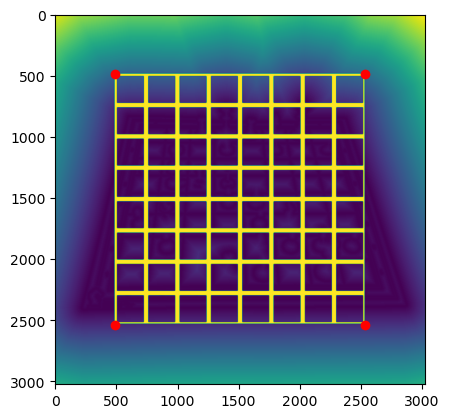

In [138]:
square_size = 32
H, W = 3024,3024

def getStructBoard() -> torch.tensor:
    board_size = square_size*8
    res = torch.zeros(board_size, board_size)

    for val in range(-2, 3):
        res[np.arange(val, board_size, square_size), :] = 1
        res[:, np.arange(val, board_size, square_size)] = 1

    return res


def warp(src_pts, dst_pts, image, newSize=(square_size*8, square_size*8)):
    M = cv2.getPerspectiveTransform(src_pts.numpy(), dst_pts.numpy())
    warppedImg = cv2.warpPerspective(image.numpy(), M, newSize)
    return M, warppedImg


def reverseWarp(dst_pts, src_pts=None, newSize=(W,H)):
    if (src_pts is None):
        src_pts = torch.tensor([
            [0,0],
            [256,0],
            [256,256],
            [0,256],
        ], dtype=torch.float32).to(device)

    image = getStructBoard()
    return warp(src_pts, dst_pts, image, newSize)

def calc_error(warpped_board):
    return torch.mean((d * warpped_board)**2)

factor = 256 * 8
dst_pts = torch.tensor([
    [(W-factor)/2, (H-factor)/2],
    [(W+factor)/2, (H-factor)/2],
    [(W+factor)/2, (H+factor)/2],
    [(W-factor)/2, (H+factor)/2],
], dtype=torch.float32).to(device)

M, warpping = reverseWarp(dst_pts)
plt.imshow(d);
plt.imshow(warpping, alpha=warpping)
plt.scatter(dst_pts[:,0], dst_pts[:,1], c='red')
M, warpping.shape, calc_error(warpping)

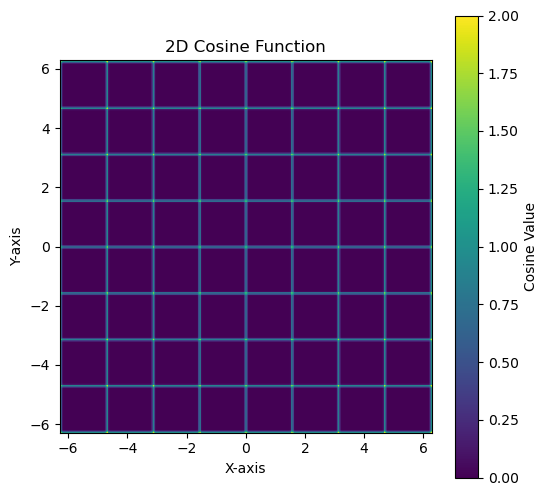

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def cos_comp(val):
    A = 1      # Amplitude
    f = np.pi/16     # Frequency
    p = 100
    return (A * np.maximum(np.cos(f*val), 0))**p

# Define the grid with higher resolution
x = np.linspace(0, 256, 256)  # Increase resolution
y = np.linspace(0, 256, 256)
X, Y = np.meshgrid(x, y)

# Define the cosine function with variable frequency
A = 1      # Amplitude
f = np.pi/16     # Frequency
p = 100
Z = cos_comp(X) + cos_comp(Y)

# Plot the updated 2D cosine function
plt.figure(figsize=(6,6))
plt.imshow(Z, extent=[-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi], origin='lower')
plt.colorbar(label="Cosine Value")
plt.title(f"2D Cosine Function")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


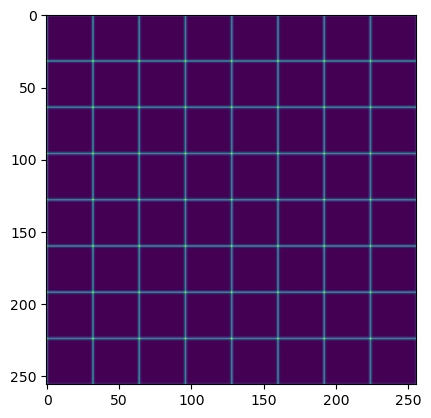

In [4]:
tmp = torch.cartesian_prod(torch.arange(0, 256, 1), torch.arange(0, 256, 1)).view((256, 256, 2))
tmp[:,:,[0,1]] = tmp[:,:,[1,0]]
# coord = torch.cat((tmp, torch.ones((256, 256, 1))), dim=2)

ced = (torch.relu(torch.cos(np.pi/16 * tmp)) ** 100)
ced = ced[:,:,0] + ced[:,:,1]
# ced = (torch.cos(3.14/16 * tmp) ** 100).max(dim=2).values

plt.imshow(ced);
# plt.imshow(lined_img);

# ((ced - lined_img)**2).sum()

In [ ]:
import torch
import torch.nn.functional as F

import cv2

from PIL import Image

H, W = 3024, 3024

src_pts = torch.tensor([
    [0,0],
    [256,0],
    [256,256],
    [0,256],
], dtype=torch.float32).to(device)

dst_pts = torch.nn.Parameter(torch.tensor([
    [(W-256)/2, (H-256)/2],
    [(W+256)/2, (H-256)/2],
    [(W+256)/2, (H+256)/2],
    [(W-256)/2, (H+256)/2],
],
requires_grad=True))

optimizer = torch.optim.Adam([dst_pts], lr=1e7)
dst_pts

Parameter containing:
tensor([[1384., 1384.],
        [1640., 1384.],
        [1640., 1640.],
        [1384., 1640.]], requires_grad=True)

In [74]:
# Normalize points
def normalize_pts(pts, img_size):
    return (pts - img_size / 2) / (img_size / 2)

# Denormalize points
def denormalize_pts(pts, img_size):
    return pts * (img_size / 2) + (img_size / 2)

In [75]:
def warp_coordinates(x_prime, y_prime, M_inv):
    """Warp (x', y') back to (x, y) using the inverse transform."""
    ones = torch.ones_like(x_prime)
    coords = torch.stack([x_prime, y_prime, ones], dim=0)  # Shape (3, N)
    warped = torch.matmul(M_inv, coords)  # Apply inverse M
    x = warped[0] / warped[2]  # Normalize
    y = warped[1] / warped[2]
    return x, y


In [76]:
def chessboard_edges(x, y):
    """Compute the warped chessboard edges."""
    pi_16 = torch.tensor(torch.pi / 16)
    cos_x = torch.cos(pi_16 * x)
    cos_y = torch.cos(pi_16 * y)
    
    # Apply ReLU and exponentiation
    edges_x = F.relu(cos_x) ** 100
    edges_y = F.relu(cos_y) ** 100
    
    return edges_x + edges_y  # Combine horizontal and vertical edges


In [88]:
def compute_loss(d, M):
    """Compute the error measure E = sum(d * warped_edges)."""
    M_inv = torch.inverse(M)  # Compute M^-1
    H, W = d.shape  # Image dimensions
    
    # Generate pixel coordinates (x', y')
    x_prime = torch.linspace(0, W-1, W).repeat(H, 1).flatten()
    y_prime = torch.linspace(0, H-1, H).repeat(W, 1).T.flatten()
    
    # Warp coordinates
    x, y = warp_coordinates(x_prime, y_prime, M_inv)
    
    # Compute warped chessboard function
    warped_edges = chessboard_edges(x, y)
    
    # Compute error
    return torch.sum(d.flatten() * warped_edges)


In [78]:
def compute_perspective_matrix(src, dst):
    """
    Compute the 3x3 perspective transform matrix M using PyTorch operations.
    src: (4,2) tensor of source points
    dst: (4,2) tensor of destination points
    Returns: (3,3) perspective transformation matrix M
    """
    assert src.shape == (4, 2) and dst.shape == (4, 2), "Source and destination points must be (4,2)"
    
    # Construct the A matrix (8x8) and B vector (8x1)
    A = []
    B = []
    
    for (x_src, y_src), (x_dst, y_dst) in zip(src, dst):
        A.append([x_src, y_src, 1, 0, 0, 0, -x_dst*x_src, -x_dst*y_src])
        A.append([0, 0, 0, x_src, y_src, 1, -y_dst*x_src, -y_dst*y_src])
        B.append(x_dst)
        B.append(y_dst)
    
    A = torch.tensor(A, dtype=torch.float32, requires_grad=True)  # Make sure A is trainable
    B = torch.tensor(B, dtype=torch.float32, requires_grad=True)

    # Solve Ax = B using torch.linalg.lstsq
    # X, _ = torch.linalg.lstsq(A, B).solution.split([8])  # Extract the first 8 values
    X = torch.linalg.lstsq(A, B).solution[:8]  # ✅ Correct


    # Reshape to form 3x3 matrix
    M = torch.cat([X, torch.tensor([1.0])], dim=0).reshape(3, 3)

    return M

In [89]:
for i in tqdm(range(50)):  # 500 iterations
    optimizer.zero_grad()
    M = compute_perspective_matrix(src_pts, dst_pts)
    loss = compute_loss(d, M)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update dst_pts
    
    if i % 1 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Loss = 170474864.0
Iteration 1: Loss = 170477376.0
Iteration 2: Loss = 170473504.0
Iteration 3: Loss = 170477840.0
Iteration 4: Loss = 170477664.0


KeyboardInterrupt: 

In [69]:
dst_pts

Parameter containing:
tensor([[1384., 1384.],
        [1640., 1384.],
        [1640., 1640.],
        [1384., 1640.]], requires_grad=True)

In [82]:
import torch

def compute_perspective_matrix(src, dst):
    """
    Compute the 3x3 perspective transform matrix M using PyTorch operations.
    src: (4,2) tensor of source points
    dst: (4,2) tensor of destination points
    Returns: (3,3) perspective transformation matrix M
    """
    assert src.shape == (4, 2) and dst.shape == (4, 2), "Source and destination points must be (4,2)"
    
    A = []
    B = []
    
    for (x_src, y_src), (x_dst, y_dst) in zip(src, dst):
        A.append([x_src, y_src, 1, 0, 0, 0, -x_dst*x_src, -x_dst*y_src])
        A.append([0, 0, 0, x_src, y_src, 1, -y_dst*x_src, -y_dst*y_src])
        B.append(x_dst)
        B.append(y_dst)
    
    A = torch.tensor(A, dtype=torch.float32, requires_grad=True)
    B = torch.tensor(B, dtype=torch.float32, requires_grad=True)

    # Solve Ax = B using least squares
    X = torch.linalg.lstsq(A, B).solution[:8]

    # Form 3x3 perspective matrix
    M = torch.cat([X, torch.tensor([1.0])], dim=0).reshape(3, 3)

    return M

# Normalize points
def normalize_pts(pts, img_size):
    return (pts - img_size / 2) / (img_size / 2)

# Denormalize points
def denormalize_pts(pts, img_size):
    return pts * (img_size / 2) + (img_size / 2)

# Training loop to optimize dst_points
def optimize_dst_points(src_pts, dst_pts, edge_image, num_iters=500, lr=1e-3, img_size=3024):
    dst_pts = torch.nn.Parameter(dst_pts)  # Ensure dst_pts is learnable
    optimizer = torch.optim.Adam([dst_pts], lr=lr)

    for i in range(num_iters):
        optimizer.zero_grad()

        # Compute perspective matrix
        M = compute_perspective_matrix(src_pts, dst_pts)

        # Convert M to 4D affine format (for affine_grid)
        M_affine = M[:2].unsqueeze(0)  # (2,3) -> (1,2,3)

        # Generate grid for transformation
        grid = F.affine_grid(M_affine, size=edge_image.shape, align_corners=False)
        
        # Apply transformation
        warped_edges = F.grid_sample(edge_image, grid, align_corners=False)

        # # Compute perspective matrix
        # M = compute_perspective_matrix(src_pts, dst_pts)

        # # Warp the predicted chessboard edge map
        # grid = torch.nn.functional.affine_grid(M[:2].unsqueeze(0), edge_image.shape, align_corners=False)
        # warped_edges = torch.nn.functional.grid_sample(edge_image, grid, align_corners=False)

        # Compute loss (Mean Squared Error)
        loss = torch.mean((warped_edges - edge_image) ** 2)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")

    return dst_pts

# Example setup
img_size = 3024
H, W = 3024, 3024

src_points = torch.tensor([
    [0, 0],
    [256, 0],
    [256, 256],
    [0, 256],
], dtype=torch.float32)

dst_points = torch.tensor([
    [(W-256)/2, (H-256)/2],
    [(W+256)/2, (H-256)/2],
    [(W+256)/2, (H+256)/2],
    [(W-256)/2, (H+256)/2],
], dtype=torch.float32, requires_grad=True)

# Optimize dst points
optimized_dst_points = optimize_dst_points(src_points, dst_points, d)

print("Optimized dst points:", optimized_dst_points)


NotImplementedError: affine_grid only supports 4D and 5D sizes, for 2D and 3D affine transforms, respectively. Got size torch.Size([3024, 3024]).

In [86]:
import torch
import torch.nn.functional as F

def compute_perspective_matrix(src, dst):
    """
    Compute the 3x3 perspective transform matrix M using PyTorch operations.
    src: (4,2) tensor of source points
    dst: (4,2) tensor of destination points
    Returns: (3,3) perspective transformation matrix M
    """
    assert src.shape == (4, 2) and dst.shape == (4, 2), "Source and destination points must be (4,2)"
    
    A = []
    B = []
    
    for (x_src, y_src), (x_dst, y_dst) in zip(src, dst):
        A.append([x_src, y_src, 1, 0, 0, 0, -x_dst*x_src, -x_dst*y_src])
        A.append([0, 0, 0, x_src, y_src, 1, -y_dst*x_src, -y_dst*y_src])
        B.append(x_dst)
        B.append(y_dst)
    
    A = torch.tensor(A, dtype=torch.float32, requires_grad=True)
    B = torch.tensor(B, dtype=torch.float32, requires_grad=True)

    # Solve Ax = B using least squares
    X = torch.linalg.lstsq(A, B).solution[:8]

    # Form 3x3 perspective matrix
    M = torch.cat([X, torch.tensor([1.0])], dim=0).reshape(3, 3)

    return M

def warp_perspective(image, M):
    """
    Apply a perspective warp using PyTorch (instead of OpenCV) to maintain autograd.
    """
    H, W = image.shape[-2:]  # Image dimensions
    device = image.device

    # Generate mesh grid for pixel coordinates
    y, x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')

    # Convert to homogeneous coordinates (x, y, 1)
    ones = torch.ones_like(x, dtype=torch.float32)
    coords = torch.stack([x, y, ones], dim=0).reshape(3, -1)  # Shape: (3, H*W)

    # Apply transformation: new_coords = M * coords
    new_coords = M @ coords

    # Normalize by w' (perspective division)
    new_x = new_coords[0] / new_coords[2]
    new_y = new_coords[1] / new_coords[2]

    # Reshape back to grid shape
    new_x = new_x.view(H, W)
    new_y = new_y.view(H, W)

    # Normalize coordinates to [-1, 1] range for grid_sample
    new_x = 2 * (new_x / (W - 1)) - 1
    new_y = 2 * (new_y / (H - 1)) - 1

    # Stack new_x and new_y into a sampling grid
    grid = torch.stack([new_x, new_y], dim=-1).unsqueeze(0)  # Shape: (1, H, W, 2)

    # Ensure image is 4D (batch, channels, H, W)
    if image.dim() == 2:
        image = image.unsqueeze(0).unsqueeze(0)

    # Sample from the original image using bilinear interpolation
    warped_image = F.grid_sample(image, grid, mode='bilinear', padding_mode='border', align_corners=True)

    return warped_image.squeeze(0)  # Remove batch dimension

# Optimization loop to find best dst_pts
def optimize_dst_points(src_pts, dst_pts, edge_image, num_iters=20, lr=1e-3):
    dst_pts = torch.nn.Parameter(dst_pts.clone())  # Ensure dst_pts is learnable
    optimizer = torch.optim.Adam([dst_pts], lr=lr)

    for i in range(num_iters):
        optimizer.zero_grad()

        # Compute perspective matrix
        M = compute_perspective_matrix(src_pts, dst_pts)

        # Warp edge image
        warped_edges = warp_perspective(edge_image, M)

        # Compute loss (Mean Squared Error)
        loss = torch.mean((warped_edges - edge_image) ** 2)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if i % 1 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")

    return dst_pts

# Example setup
img_size = 1
H, W = 3024, 3024

src_points = torch.tensor([
    [0, 0],
    [256, 0],
    [256, 256],
    [0, 256],
], dtype=torch.float32).to(device) / 256

dst_points = torch.tensor([
    [(W-256)/2, (H-256)/2],
    [(W+256)/2, (H-256)/2],
    [(W+256)/2, (H+256)/2],
    [(W-256)/2, (H+256)/2],
], dtype=torch.float32, requires_grad=True).to(device) / 3024

# Optimize dst points
optimized_dst_points = optimize_dst_points(src_points, dst_points, d.to(device))

print("Optimized dst points:", optimized_dst_points)


Iteration 0: Loss = 438383.21875
Iteration 1: Loss = 440103.09375
Iteration 2: Loss = 438383.21875
Iteration 3: Loss = 438139.84375
Iteration 4: Loss = 438139.84375


KeyboardInterrupt: 

In [139]:
import torch
import numpy as np
import cv2
from scipy.optimize import least_squares

def distance_transform(edges):
    """Computes the Euclidean distance transform of an edge-detected image."""
    edges_np = edges.astype(np.uint8)  # Convert to uint8
    dt = cv2.distanceTransform(255 - edges_np, cv2.DIST_L2, 5)
    return dt

def chessboard_edges(grid_size=256):
    """Generates a chessboard-like edge image based on cosine functions."""
    x = np.arange(grid_size)
    X, Y = np.meshgrid(x, x)

    edge_mask = (np.maximum(0, np.cos(np.pi / 16 * X))**100 + 
                 np.maximum(0, np.cos(np.pi / 16 * Y))**100)
    
    return edge_mask

def compute_homography(src_pts, dst_pts):
    """Computes the perspective transformation matrix M using least squares."""
    A = []
    for (x_src, y_src), (x_dst, y_dst) in zip(src_pts, dst_pts):
        A.append([x_src, y_src, 1, 0, 0, 0, -x_dst*x_src, -x_dst*y_src, -x_dst])
        A.append([0, 0, 0, x_src, y_src, 1, -y_dst*x_src, -y_dst*y_src, -y_dst])

    A = np.array(A, dtype=np.float32)

    # Solve Ax = 0 using SVD
    U, S, Vh = np.linalg.svd(A)
    M = Vh[-1].reshape(3, 3)  # Last row of Vh is the solution
    return M / M[2, 2]  # Normalize so that M[2,2] = 1

def warp_image(image, M):
    """Applies a perspective warp to the image using OpenCV."""
    H, W = 3024,3024
    return torch.tensor(cv2.warpPerspective(image, M, (W, H), flags=cv2.INTER_LINEAR), dtype=torch.float32)

def error_function(dst_pts_flat, src_pts, chessboard_edges, distance_map):
    """
    Computes the error function given flattened dst_pts, source points, 
    chessboard edges, and distance transform.
    """
    # Reshape dst_pts from flattened form
    dst_pts = dst_pts_flat.reshape(4, 2)

    # Compute transformation matrix M
    M = compute_homography(src_pts, dst_pts)

    # Warp the chessboard edges
    warped_chessboard = warp_image(chessboard_edges, M)

    # Compute error as sum of weighted distance transform
    error = torch.sum(distance_map * warped_chessboard)
    
    return error

# Load edge-detected image (assumed to be preprocessed)
# edge_detected = np.random.rand(256, 256) * 255  # Simulated edge-detected image
distance_map = d

# Define source points (chessboard corners in a 256x256 grid)
src_pts = torch.tensor([[0, 0], [255, 0], [255, 255], [0, 255]], dtype=torch.float32)

# Initial guess for destination points
# dst_pts_initial = torch.tensor([[30, 40], [220, 30], [230, 230], [20, 240]], dtype=torch.float32)

H, W = 3024, 3024

factor = 256 * 8
dst_pts_initial = torch.tensor([
    [(W-factor)/2, (H-factor)/2],
    [(W+factor)/2, (H-factor)/2],
    [(W+factor)/2, (H+factor)/2],
    [(W-factor)/2, (H+factor)/2],
], dtype=torch.float32)

# Use scipy.optimize.least_squares to minimize the error function
result = least_squares(error_function, dst_pts_initial.flatten(), args=(src_pts, chessboard_edges(), distance_map))

# Extract optimized dst_pts
optimized_dst_pts = result.x.reshape(4, 2)

# Compute final M
M_final = compute_homography(src_pts, optimized_dst_pts)

# Print results
print("Optimized dst_pts:", optimized_dst_pts)
print("Optimized Homography Matrix:\n", M_final)
print(dst_pts_initial)


Optimized dst_pts: [[ 488.  488.]
 [2536.  488.]
 [2536. 2536.]
 [ 488. 2536.]]
Optimized Homography Matrix:
 [[ 8.0313721e+00  2.1509435e-11  4.8799997e+02]
 [-4.9786585e-12  8.0313721e+00  4.8799997e+02]
 [ 4.1759399e-14 -3.4868301e-14  1.0000000e+00]]
tensor([[ 488.,  488.],
        [2536.,  488.],
        [2536., 2536.],
        [ 488., 2536.]])


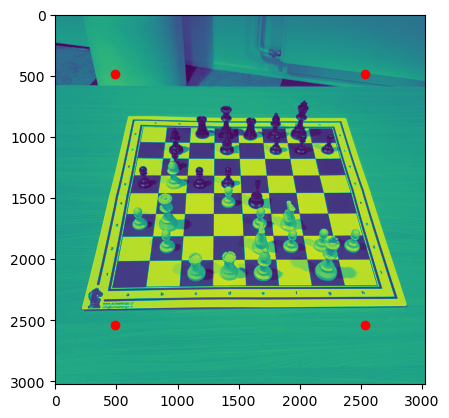

In [140]:
plt.scatter(optimized_dst_pts[:,0], optimized_dst_pts[:,1], c='red');
plt.imshow(img_gray);